# Visualization Setup

results.zip 처리 후 시퀀스/임베딩을 로드하고, collapse 분석용 지표와 시각화를 수행합니다.


In [1]:
import sys
from pathlib import Path

current_dir = Path('.').resolve()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


In [2]:
import shutil
import zipfile
import zlib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from metrics_utils import (
    cosine_series_from_embeddings,
    compute_gc_content,
    calculate_shannon_entropy,
    compute_vendi_score,
)


In [3]:
RESULTS_ZIP = Path('results.zip')
RESULTS_DIR = Path('results')

if RESULTS_ZIP.exists():
    if RESULTS_DIR.exists():
        shutil.rmtree(RESULTS_DIR)
    with zipfile.ZipFile(RESULTS_ZIP, 'r') as zf:
        zf.extractall(RESULTS_DIR)
    RESULTS_ZIP.unlink()
    print('results.zip extracted and cleaned')
else:
    print('results.zip not found; using existing results directory')


results.zip not found; using existing results directory


In [4]:
# Load sequences
SEQ_DIR = RESULTS_DIR / 'sequences'
all_sequences = {}

if SEQ_DIR.exists():
    for model_dir in sorted([p for p in SEQ_DIR.iterdir() if p.is_dir()]):
        model_name = model_dir.name
        all_sequences[model_name] = {}
        for csv_file in sorted(model_dir.glob('*.csv')):
            gene_id = csv_file.stem
            df = pd.read_csv(csv_file, index_col=0)
            sequences_dict = {strategy: df.loc[strategy].tolist() for strategy in df.index}
            all_sequences[model_name][gene_id] = sequences_dict
    print('Sequences loaded:', list(all_sequences.keys()))
else:
    print('WARNING: sequences directory not found:', SEQ_DIR)


Sequences loaded: ['DNABERT-2', 'NT-v2-500m', 'NT-v2-50m']


In [5]:
# Load embeddings
EMBEDDINGS_DIR = RESULTS_DIR / 'embeddings'
all_embeddings = {}

if EMBEDDINGS_DIR.exists():
    for pkl_file in sorted(EMBEDDINGS_DIR.glob('embeddings_*__by__*.pkl')):
        stem = pkl_file.stem
        name = stem.replace('embeddings_', '', 1)
        if '__by__' not in name:
            continue
        gen_label, eval_label = name.split('__by__', 1)
        with open(pkl_file, 'rb') as f:
            all_embeddings[(gen_label, eval_label)] = pickle.load(f)
    print('Embeddings loaded:', len(all_embeddings))
else:
    print('WARNING: embeddings directory not found:', EMBEDDINGS_DIR)

model_order = ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']
self_embeddings = {k[0]: v for k, v in all_embeddings.items() if k[0] == k[1]}
self_embeddings_keys = [m for m in model_order if m in self_embeddings]
self_embeddings_keys += [m for m in self_embeddings.keys() if m not in self_embeddings_keys]
print('Self-eval models:', self_embeddings_keys)


Embeddings loaded: 9
Self-eval models: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']


## Step 2: Feature Engineering & Metric Extraction

Iteration/Model/Strategy/Gene 기준으로 시각화용 지표를 미리 계산합니다.


In [6]:
def sequence_complexity(seq):
    if not seq:
        return None
    raw = seq.encode('utf-8')
    return len(zlib.compress(raw)) / len(raw)

def safe_gc_percent(seq):
    if not seq:
        return None
    return compute_gc_content(seq) * 100.0

def build_metrics_df(all_sequences, self_embeddings, model_keys):
    records = []
    for model_label in model_keys:
        seqs_model = all_sequences.get(model_label, {})
        emb_model = self_embeddings.get(model_label, {})
        for gene_id, strategies in seqs_model.items():
            for strategy_key, seq_list in strategies.items():
                if not seq_list:
                    continue
                embs = emb_model.get(gene_id, {}).get(strategy_key, [])
                sims = cosine_series_from_embeddings(embs)
                seq0 = seq_list[0] if seq_list else ''
                gc0 = safe_gc_percent(seq0) if seq0 else None
                for idx, seq in enumerate(seq_list):
                    if not isinstance(seq, str) or not seq:
                        continue
                    gc = safe_gc_percent(seq)
                    entropy = calculate_shannon_entropy(seq)
                    complexity = sequence_complexity(seq)
                    sim = sims[idx] if idx < len(sims) else None
                    gc_delta = abs(gc - gc0) if gc is not None and gc0 is not None else None
                    records.append({
                        'Model': model_label,
                        'Strategy': strategy_key,
                        'Gene': gene_id,
                        'Iteration': idx,
                        'Similarity': sim,
                        'GC': gc,
                        'GC_Delta': gc_delta,
                        'Entropy': entropy,
                        'Complexity': complexity,
                        'Length': len(seq),
                    })
    return pd.DataFrame(records)

def build_vendi_df(self_embeddings, model_keys, max_samples=200, seed=7):
    rng = np.random.default_rng(seed)
    records = []
    for model_label in model_keys:
        emb_model = self_embeddings.get(model_label, {})
        per_strategy_iter = {}
        for gene_id, strategies in emb_model.items():
            for strategy_key, embs in strategies.items():
                for idx, emb in enumerate(embs):
                    if emb is None:
                        continue
                    per_strategy_iter.setdefault(strategy_key, {}).setdefault(idx, []).append(emb)
        for strategy_key, iter_map in per_strategy_iter.items():
            for idx, embs in iter_map.items():
                arr = np.asarray(embs)
                if arr.ndim == 1:
                    arr = arr.reshape(1, -1)
                if arr.shape[0] == 0:
                    continue
                if max_samples and arr.shape[0] > max_samples:
                    sample_idx = rng.choice(arr.shape[0], size=max_samples, replace=False)
                    arr = arr[sample_idx]
                vendi = compute_vendi_score(arr)
                records.append({
                    'Model': model_label,
                    'Strategy': strategy_key,
                    'Iteration': idx,
                    'Vendi': vendi,
                    'N': arr.shape[0],
                })
    return pd.DataFrame(records)

metrics_df = build_metrics_df(all_sequences, self_embeddings, self_embeddings_keys)
vendi_df = build_vendi_df(self_embeddings, self_embeddings_keys)
metrics_df.head()


,Model,Strategy,Gene,Iteration,Similarity,GC,GC_Delta,Entropy,Complexity,Length
0,DNABERT-2,greedy,GAPDH,0,1.000000,56.108949,0.000000,1.985130,0.341634,1285
1,DNABERT-2,greedy,GAPDH,1,0.979150,57.460841,1.351891,1.971854,0.333883,1213
2,DNABERT-2,greedy,GAPDH,2,0.945447,59.404255,3.295306,1.947501,0.325957,1175
3,DNABERT-2,greedy,GAPDH,3,0.959378,62.133333,6.024384,1.927463,0.328000,1125
4,DNABERT-2,greedy,GAPDH,4,0.889772,63.443831,7.334881,1.880019,0.313996,1086


## Step 3: Collapse across Decoding Strategies

Similarity(성능)와 Vendi(다양성)를 같은 축에서 비교해 전략별 균형점을 확인합니다.


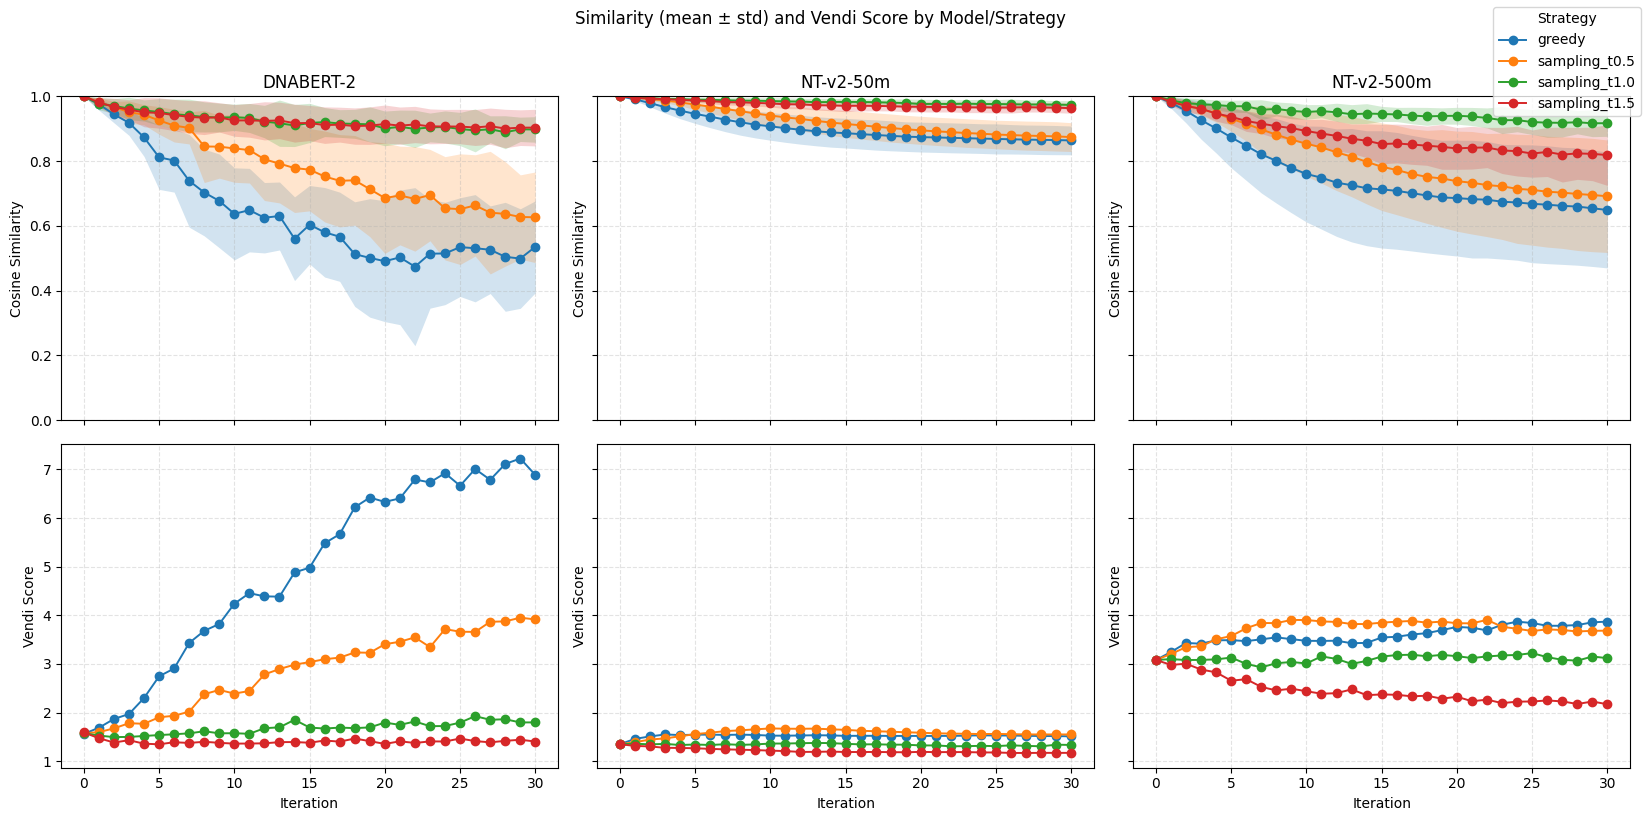

In [7]:
# Similarity (mean ± std) and Vendi Score split view
sim_summary = metrics_df.dropna(subset=['Similarity']).groupby(
    ['Model', 'Strategy', 'Iteration'], as_index=False
).agg(MeanSimilarity=('Similarity', 'mean'), StdSimilarity=('Similarity', 'std'))

vendi_summary = vendi_df.copy()

strategy_order = list(dict.fromkeys(sim_summary['Strategy'].tolist()))
palette = sns.color_palette('tab10', n_colors=max(1, len(strategy_order)))
strategy_colors = {s: palette[i % len(palette)] for i, s in enumerate(strategy_order)}

# Global y-limits for consistency
sim_ylim = (0.0, 1.0)
if not vendi_summary.empty:
    vmin = float(vendi_summary['Vendi'].min())
    vmax = float(vendi_summary['Vendi'].max())
    pad = 0.05 * (vmax - vmin) if vmax > vmin else 0.1
    vendi_ylim = (vmin - pad, vmax + pad)
else:
    vendi_ylim = (0.0, 1.0)

fig, axes = plt.subplots(2, 3, figsize=(16.5, 8.0), sharex=True, sharey='row')

for col_idx, model_label in enumerate(self_embeddings_keys):
    ax_top = axes[0, col_idx]
    ax_bot = axes[1, col_idx]

    sim_subset = sim_summary[sim_summary['Model'] == model_label]
    vendi_subset = vendi_summary[vendi_summary['Model'] == model_label]

    for strategy_key in strategy_order:
        df_s = sim_subset[sim_subset['Strategy'] == strategy_key]
        if df_s.empty:
            continue
        color = strategy_colors.get(strategy_key)
        ax_top.plot(
            df_s['Iteration'],
            df_s['MeanSimilarity'],
            marker='o',
            linewidth=1.4,
            color=color,
            label=strategy_key,
        )
        if df_s['StdSimilarity'].notna().any():
            ax_top.fill_between(
                df_s['Iteration'],
                df_s['MeanSimilarity'] - df_s['StdSimilarity'].fillna(0),
                df_s['MeanSimilarity'] + df_s['StdSimilarity'].fillna(0),
                color=color,
                alpha=0.2,
                linewidth=0,
            )

        df_v = vendi_subset[vendi_subset['Strategy'] == strategy_key]
        if df_v.empty:
            continue
        ax_bot.plot(
            df_v['Iteration'],
            df_v['Vendi'],
            marker='o',
            linewidth=1.4,
            color=color,
            label=strategy_key,
        )

    ax_top.set_title(model_label)
    ax_top.set_ylim(sim_ylim)
    ax_top.set_ylabel('Cosine Similarity')
    ax_top.grid(True, linestyle='--', alpha=0.35)

    ax_bot.set_ylim(vendi_ylim)
    ax_bot.set_ylabel('Vendi Score')
    ax_bot.set_xlabel('Iteration')
    ax_bot.grid(True, linestyle='--', alpha=0.35)

# Legend on the first column
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title='Strategy', loc='upper right', frameon=True)

fig.suptitle('Similarity (mean ± std) and Vendi Score by Model/Strategy', y=1.02)
fig.tight_layout()
plt.show()


**해석 가이드**
- Similarity는 유지되면서 Vendi가 0으로 떨어지지 않는 전략이 균형적입니다.
- Sampling t=1.0이 안정적으로 보존되면 이후 분석에서 기준 전략으로 사용합니다.


## Step 4: Collapse across Gene Properties (Sampling t=1.0)


In [8]:
STRATEGY_FOCUS = 'sampling_t1.0'
focus_df = metrics_df[metrics_df['Strategy'] == STRATEGY_FOCUS].copy()

init_df = focus_df[focus_df['Iteration'] == 0][['Model', 'Gene', 'GC', 'Length']].rename(
    columns={'GC': 'GC_Init', 'Length': 'Length_Init'}
)

slope_records = []
for (model_label, gene_id), group in focus_df.dropna(subset=['Similarity']).groupby(['Model', 'Gene']):
    if len(group) < 2:
        continue
    x = group['Iteration'].to_numpy(dtype=float)
    y = group['Similarity'].to_numpy(dtype=float)
    slope = float(np.polyfit(x, y, 1)[0])
    slope_records.append({
        'Model': model_label,
        'Gene': gene_id,
        'DecayRate': slope,
    })

slope_df = pd.DataFrame(slope_records)
EXCLUDE_GENES = {'TTN'}
slope_df = slope_df.merge(init_df, on=['Model', 'Gene'], how='left')


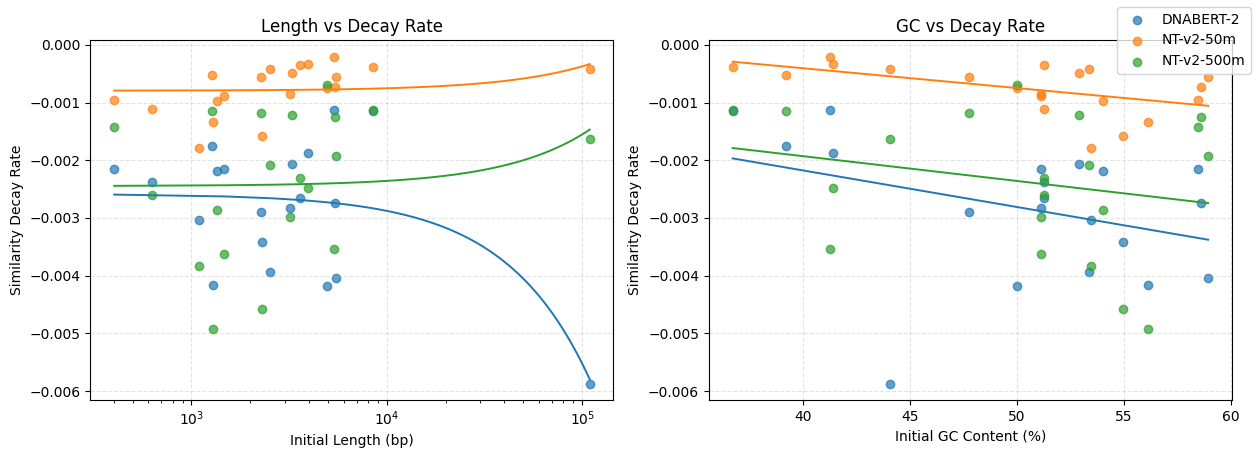

In [ ]:
# Visualization 2: Length/GC vs Similarity Decay Rate
palette = sns.color_palette('tab10', n_colors=max(1, len(self_embeddings_keys)))
model_colors = {m: palette[i % len(palette)] for i, m in enumerate(self_embeddings_keys)}

fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
for model_label in self_embeddings_keys:
    subset = slope_df[slope_df['Model'] == model_label].dropna(subset=['Length_Init', 'GC_Init', 'DecayRate'])
    if subset.empty:
        continue
    color = model_colors.get(model_label)
    axes[0].scatter(subset['Length_Init'], subset['DecayRate'], color=color, alpha=0.7, label=model_label)
    if len(subset) > 1:
        xs = np.linspace(subset['Length_Init'].min(), subset['Length_Init'].max(), 100)
        coef = np.polyfit(subset['Length_Init'], subset['DecayRate'], 1)
        axes[0].plot(xs, np.polyval(coef, xs), color=color, linewidth=1.4)

    axes[1].scatter(subset['GC_Init'], subset['DecayRate'], color=color, alpha=0.7)
    if len(subset) > 1:
        xs = np.linspace(subset['GC_Init'].min(), subset['GC_Init'].max(), 100)
        coef = np.polyfit(subset['GC_Init'], subset['DecayRate'], 1)
        axes[1].plot(xs, np.polyval(coef, xs), color=color, linewidth=1.4)

axes[0].set_xlabel('Initial Length (bp)')
axes[0].set_xscale('log')
axes[0].set_ylabel('Similarity Decay Rate')
axes[0].set_title('Length vs Decay Rate')
axes[0].grid(True, linestyle='--', alpha=0.35)

axes[1].set_xlabel('Initial GC Content (%)')
axes[1].set_ylabel('Similarity Decay Rate')
axes[1].set_title('GC vs Decay Rate')
axes[1].grid(True, linestyle='--', alpha=0.35)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right', frameon=True)
fig.tight_layout()
plt.show()


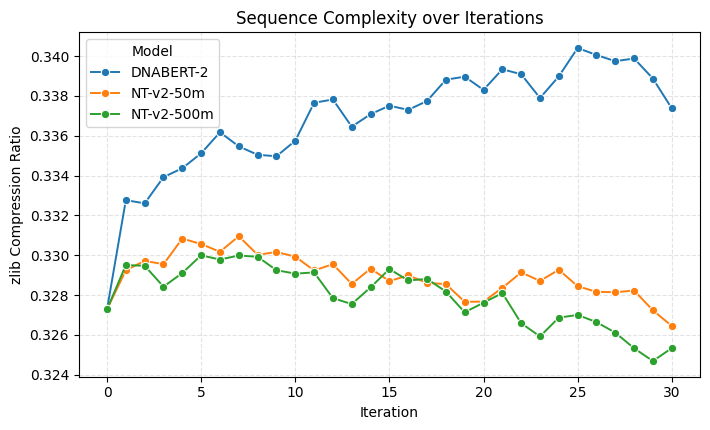

In [10]:
# Visualization 3: Structural Degradation (Complexity)
complexity_df = focus_df.dropna(subset=['Complexity']).groupby(
    ['Model', 'Iteration'], as_index=False
).agg({'Complexity': 'mean'})

fig, ax = plt.subplots(figsize=(7.2, 4.4))
sns.lineplot(
    data=complexity_df,
    x='Iteration',
    y='Complexity',
    hue='Model',
    hue_order=self_embeddings_keys,
    marker='o',
    linewidth=1.4,
    ax=ax,
)
ax.set_title('Sequence Complexity over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('zlib Compression Ratio')
ax.grid(True, linestyle='--', alpha=0.35)
ax.legend(title='Model')
fig.tight_layout()
plt.show()


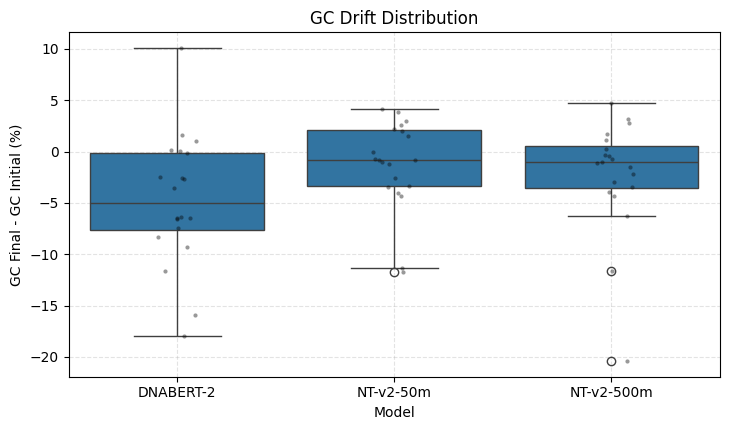

In [11]:
# Visualization 4: GC Drift Distribution
final_df = focus_df.sort_values('Iteration').groupby(['Model', 'Gene'], as_index=False).tail(1)
final_df = final_df[['Model', 'Gene', 'GC']].rename(columns={'GC': 'GC_Final'})
gc_drift_df = init_df.merge(final_df, on=['Model', 'Gene'], how='inner')
gc_drift_df['GC_Drift'] = gc_drift_df['GC_Final'] - gc_drift_df['GC_Init']

fig, ax = plt.subplots(figsize=(7.4, 4.4))
sns.boxplot(
    data=gc_drift_df,
    x='Model',
    y='GC_Drift',
    order=self_embeddings_keys,
    ax=ax,
)
sns.stripplot(
    data=gc_drift_df,
    x='Model',
    y='GC_Drift',
    order=self_embeddings_keys,
    color='black',
    alpha=0.4,
    size=3,
    ax=ax,
)
ax.set_title('GC Drift Distribution')
ax.set_xlabel('Model')
ax.set_ylabel('GC Final - GC Initial (%)')
ax.grid(True, linestyle='--', alpha=0.35)
fig.tight_layout()
plt.show()


**해석 가이드**
- DecayRate가 더 음수일수록 빠르게 붕괴합니다.
- Complexity가 감소하면 단순 반복 구조로 붕괴하는 경향입니다.
- GC Drift 분포가 한쪽으로 치우치면 GC bias 가능성이 있습니다.


## Step 5: Cross-Validation & Model Confidence


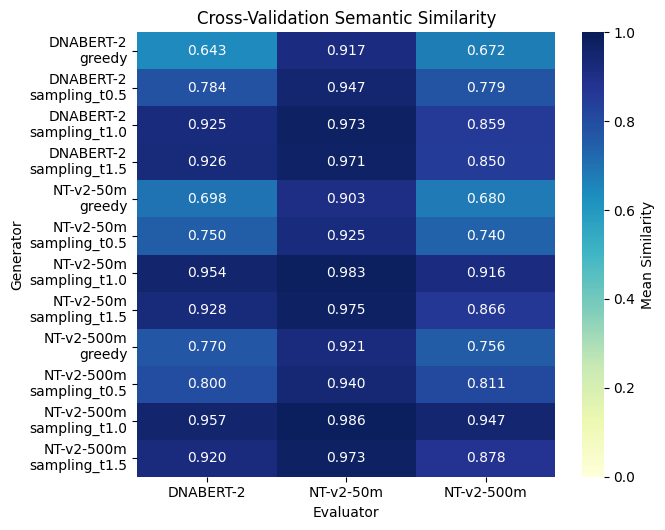

In [12]:
from visualization import plot_cross_validation_heatmap

base_model = self_embeddings_keys[0] if self_embeddings_keys else None
if base_model:
    first_gene = next(iter(self_embeddings[base_model].values()), {})
    strategy_order = list(first_gene.keys()) if first_gene else []
else:
    strategy_order = []

generator_labels = [
    (model_name, strategy_key)
    for model_name in self_embeddings_keys
    for strategy_key in strategy_order
]

if generator_labels:
    plot_cross_validation_heatmap(
        all_embeddings,
        generator_labels=generator_labels,
        evaluator_labels=self_embeddings_keys,
        iteration_range=(0, 50),
    )
else:
    print('WARNING: no generator labels for heatmap')


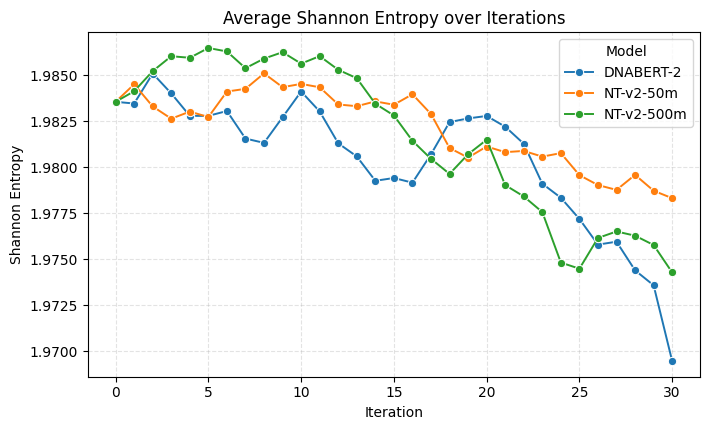

In [13]:
# Visualization 6: Model Confidence Trend (Entropy)
entropy_df = focus_df.dropna(subset=['Entropy']).groupby(
    ['Model', 'Iteration'], as_index=False
).agg({'Entropy': 'mean'})

fig, ax = plt.subplots(figsize=(7.2, 4.4))
sns.lineplot(
    data=entropy_df,
    x='Iteration',
    y='Entropy',
    hue='Model',
    hue_order=self_embeddings_keys,
    marker='o',
    linewidth=1.4,
    ax=ax,
)
ax.set_title('Average Shannon Entropy over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Shannon Entropy')
ax.grid(True, linestyle='--', alpha=0.35)
ax.legend(title='Model')
fig.tight_layout()
plt.show()


**해석 가이드**
- Heatmap의 비대각선이 높으면 모델 간 표현이 호환적입니다.
- Entropy가 낮아지면 더 단순한 패턴으로 고착화되는 경향입니다.
